# Как формировал датасеты для анализа недобросовестных ИП и ЮЛ с помощью данных СПАРК 

## Необходимые библиотеки

In [1]:
# для работы с БД
import pandas as pd
import numpy as np
# для визуального отслеживания прогресса длительных операций
from tqdm import tqdm

## Датасет по ИП - СПАРК

### Суммируем значения по законам - агрегируем информацию по истории закупок

In [76]:
df2 = pd.read_csv('enterpreneurs_spark_info.csv', encoding='utf-8')

In [72]:
# Список столбцов, которые необходимо пропустить при агрегации
skip_columns = {'reg_date', 'inn', 'region_name', 'region_code', 'main_okved_code', 'main_okved_name'}

# Создаем новый DataFrame для результатов
result_df = df2[list(skip_columns)].copy()

# Получаем список уникальных годов и показателей
years = set()
indicators = set()

for column in df2.columns:
    if column in skip_columns:
        continue
    parts = column.split('_')
    if len(parts) < 3:
        continue
    year = parts[1]
    indicator = parts[2]
    years.add(year)
    indicators.add(indicator)

# Преобразуем set в list и сортируем
years = sorted(list(years))
indicators = sorted(list(indicators))

# Обходим каждый год и показатель, агрегируя данные
for year in years:
    for indicator in indicators:
        # Собираем все столбцы, которые соответствуют текущему году и показателю
        columns_to_sum = [col for col in df2.columns if f'_{year}_{indicator}' in col]
        # Суммируем данные по этим столбцам, игнорируя NaN значения
        result_df[f'{year}_{indicator}'] = df2[columns_to_sum].sum(axis=1, min_count=1)

In [74]:
result_df.to_csv('test_entp_info.csv', index=False)

### Смэтчим значения с рнп, чтобы определить нужный год (то есть год, когда рассматриваемый поставщик попал в РНП)

In [18]:
test_entp_info = pd.read_csv('test_entp_info.csv', encoding='utf-8')

In [21]:
# Преобразуем столбец 'inn' в строковый тип
test_entp_info['inn'] = test_entp_info['inn'].astype(str)
# Применяем функцию, которая добавляет '0' в начало строки, если её длина равна 11
test_entp_info['inn'] = test_entp_info['inn'].apply(lambda x: '0' + x if len(x) == 11 else x)
# Создаём новый DataFrame для сохранения результатов
new_entp_info = test_entp_info.copy()
# Сохраняем новый DataFrame в CSV файл, указывая, что inn - это строка
new_entp_info.to_csv('enterpreneurs_spark_info_laws_agg.csv', index=False)

In [22]:
rnp_suppliers = pd.read_csv('rnp_suppliers.csv', encoding='utf-8', dtype={'supplier_inn': str})

In [78]:
enterpreneurs_spark = pd.read_csv('enterpreneurs_spark_info_laws_agg.csv', encoding='utf-8', dtype={'inn': str})

In [24]:
result = pd.merge(rnp_suppliers, enterpreneurs_spark, left_on='supplier_inn', right_on='inn', how='left')

In [28]:
filtered_result = result[result['supplier_inn'].str.len() == 12] # ИП имеют 12 чисел в ИНН

In [30]:
filtered_result.to_csv('rnp_enterpreneurs_info.csv', index=False)

### Агрегируем инфу по законам

In [36]:
df = pd.read_csv('rnp_enterpreneurs_info.csv', encoding='utf-8', dtype={'supplier_inn': str})

# Добавление столбцов signed_number_before_rnp и sum_before_rnp
df['signed_number_before_rnp'] = 0
df['sum_before_rnp'] = 0

# Итерация по каждой строке DataFrame
for index, row in df.iterrows():
    publish_year = row['publish_date_year']
    signed_number_before_rnp = 0
    sum_before_rnp = 0
    
    # Итерация по столбцам DataFrame
    for column in df.columns:
        if column.endswith('_SignedNumber'):
            year = int(column.split('_')[0])
            if not pd.isna(row[column]) and year <= int(publish_year):
                signed_number_before_rnp += row[column]
        elif column.endswith('_Sum'):
            year = int(column.split('_')[0])
            if not pd.isna(row[column]) and year <= int(publish_year):
                sum_before_rnp += row[column]
    
    # Запись значений в новые столбцы
    df.at[index, 'signed_number_before_rnp'] = signed_number_before_rnp
    df.at[index, 'sum_before_rnp'] = sum_before_rnp

In [37]:
df.to_csv('rnp_enterpreneurs_info_laws.csv', index=False)

In [41]:
# Выбираем нужные столбцы и переименовываем их
new_df = df[['supplier_inn', 'reg_date', 'region_code', 'region_name', 'main_okved_code', 'main_okved_name',
             'publish_date_year', 'publish_date', 'reason', 'contract_price_amount',
             'signed_number_before_rnp', 'sum_before_rnp']].copy()

new_df.rename(columns={
    'publish_date_year': 'rnp_entry_date_year',
    'publish_date': 'rnp_entry_date',
    'reason': 'rnp_reason',
    'signed_number_before_rnp': 'history_signed_contract_before_rnp',
    'sum_before_rnp': 'history_sum_price_before_rnp'
}, inplace=True)

new_df

,supplier_inn,reg_date,region_code,region_name,main_okved_code,main_okved_name,rnp_entry_date_year,rnp_entry_date,rnp_reason,contract_price_amount,history_signed_contract_before_rnp,history_sum_price_before_rnp
0,790100305411,2007-07-12,99.0,Еврейская автономная область,95.29,Ремонт прочих предметов личного потребления и ...,2018,2018-03-02,CANCEL_CONTRACT,60000.00,1,60000
1,470315042539,2012-08-08,41.0,Ленинградская область,18.12,Прочие виды полиграфической деятельности,2018,2018-03-02,CANCEL_CONTRACT,95000.00,25,8760426
2,231710329702,2012-06-13,3.0,Краснодарский край,77.11,Аренда и лизинг легковых автомобилей и легких ...,2018,2018-03-01,WINNER_DEVIATION,2649830.00,161,60026536
3,665912504111,2016-02-10,65.0,Свердловская область,73.11,Деятельность рекламных агентств,2018,2018-03-02,WINNER_DEVIATION,508640.00,29,121304151
4,260905656233,2016-05-25,7.0,Ставропольский край,33.12,Ремонт машин и оборудования,2018,2018-03-01,CANCEL_CONTRACT,10722.50,15,823499
...,...,...,...,...,...,...,...,...,...,...,...,...
13192,591107948760,2015-12-01,57.0,Пермский край,46.46,Торговля оптовая фармацевтической продукцией,2018,2018-02-08,WINNER_DEVIATION,284166.00,8,8713652
13193,595000381910,2015-09-15,57.0,Пермский край,45.20,Техническое обслуживание и ремонт автотранспор...,2018,2018-02-08,CANCEL_CONTRACT,346913.74,30,14978033
13194,741806019878,2016-02-02,75.0,Челябинская область,46.42,Торговля оптовая одеждой и обувью,2018,2018-02-19,WINNER_DEVIATION,63645.93,8,561468
13195,662302491681,2016-04-06,65.0,Свердловская область,01.13.3,Выращивание столовых корнеплодных и клубнеплод...,2018,2018-02-19,WINNER_DEVIATION,576270.00,0,0


In [44]:
new_df.to_csv('rnp_enterpreneurs_info_final.csv', index=False)

### Найдем разницу в датах реги и вхождения в РНП

In [50]:
new_df['reg_date'] = pd.to_datetime(new_df['reg_date'])
new_df['rnp_entry_date'] = pd.to_datetime(new_df['rnp_entry_date'])

# Вычисление разницы в годах
new_df['date_diff_years'] = (new_df['rnp_entry_date'].dt.year - new_df['reg_date'].dt.year)

In [53]:
new_df['date_diff'] = round(new_df['date_diff_days'] / 365, 1)

In [52]:
# Подсчет количества записей, где rnp_entry_date < reg_date
count_records = (new_df['rnp_entry_date'] < new_df['reg_date']).sum()

print("Количество записей, где rnp_entry_date < reg_date:", count_records)

Количество записей, где rnp_entry_date < reg_date: 1115


In [58]:
new_df['date_diff'] = new_df['date_diff'].apply(lambda x: np.nan if x < 0 else x)

In [61]:
# Выбираем нужные столбцы и переименовываем их
new_new_df = new_df[['supplier_inn', 'reg_date', 'region_code', 'region_name', 'main_okved_code', 'main_okved_name',
             'rnp_entry_date_year', 'rnp_entry_date', 'date_diff', 'rnp_reason', 'contract_price_amount',
             'history_signed_contract_before_rnp', 'history_sum_price_before_rnp']].copy()

new_new_df.rename(columns={
    'date_diff': 'date_diff_between_reg_entry'
}, inplace=True)

In [63]:
new_new_df.to_csv('rnp_enterpreneurs_info_final.csv', index=False)

In [64]:
df = pd.read_csv('comp_main_spark_info.csv', encoding='utf-8', dtype={'inn': str})

# Список столбцов, которые необходимо пропустить при агрегации
skip_columns = {'reg_date', 'shortname','inn', 'kpp', 'region_name', 'region_code', 'main_okved_code', 'main_okved_name'}

# Создаем новый DataFrame для результатов
result_df = df[list(skip_columns)].copy()

# Получаем список уникальных годов и показателей
years = set()
indicators = set()

for column in df.columns:
    if column in skip_columns:
        continue
    parts = column.split('_')
    if len(parts) < 3:
        continue
    year = parts[1]
    indicator = parts[2]
    years.add(year)
    indicators.add(indicator)

# Преобразуем set в list и сортируем
years = sorted(list(years))
indicators = sorted(list(indicators))

# Обходим каждый год и показатель, агрегируя данные
for year in years:
    for indicator in indicators:
        # Собираем все столбцы, которые соответствуют текущему году и показателю
        columns_to_sum = [col for col in df.columns if f'_{year}_{indicator}' in col]
        # Суммируем данные по этим столбцам, игнорируя NaN значения
        result_df[f'{year}_{indicator}'] = df[columns_to_sum].sum(axis=1, min_count=1)

In [65]:
result_df.to_csv('test_comp_info.csv', index=False)

In [73]:
result_df['inn'].value_counts()

inn
8603213388    2
7722483470    2
5005067209    2
5047169562    2
7452035322    1
             ..
4823070018    1
4823061366    1
4823060500    1
4823057264    1
9909201656    1
Name: count, Length: 23695, dtype: int64

откуда то были дубликаты, нужно их убрать

### Небольшая корректировка - нужно проработать ОКВЭД. Приведем ОКВЭД к единой структуре (классам)

In [4]:
df_entp = pd.read_csv('rnp_enterpreneurs_info_final.csv',
                      encoding='utf-8',
                      dtype={'supplier_inn': str})

In [49]:
new_column = df_entp['main_okved_code'].str[:2]
# Выбираем позицию, где должен быть вставлен новый столбец (после 5-го столбца, индексация с нуля)
position = 6

# Вставляем столбец
df_entp.insert(loc=position, column='main_okved_code_class', value=new_column)

In [26]:
# используем файл со структурой ОКВЭД
check_okved = pd.read_csv(r'D:\Рабочий стол\data-20240301-structure-20180402 (4).txt', 
                          encoding='utf-8', 
                          sep=';',
                          header=None,
                          names=['ОКВЭД', 'Коды ОКВЭД', 'Наименование разделов'])

In [28]:
check_okved.to_csv('okved_structure.csv', index=False)

Смэтчим название, соответствующее выведенному классу ОКВЭД

In [52]:
result = pd.merge(df_entp, check_okved[['Коды ОКВЭД', 'Наименование разделов']], 
                  left_on='main_okved_code_class', right_on='Коды ОКВЭД', how='left').drop(columns='Коды ОКВЭД')

In [58]:
new_column = result['Наименование разделов']
# Выбираем позицию, где должен быть вставлен новый столбец (после 6-го столбца, индексация с нуля)
position = 7
# Вставляем столбец
result.insert(loc=position, column='main_okved_name_class', value=new_column)

In [60]:
result.drop('Наименование разделов', axis=1, inplace=True)

In [62]:
result.to_csv('rnp_enterpreneurs_info_final_final.csv', index=False)

> Это финальный датасет по ИП, по которому будет проводиться анализ. Загружен в папку

## Датасет по ЮЛ - СПАРК

### Проделаем по аналогии, как с ИП

In [82]:
result_df = result_df.drop_duplicates(subset='inn', keep='first')

In [85]:
result = pd.merge(rnp_suppliers, result_df, left_on='supplier_inn', right_on='inn', how='left')
result

,supplier_inn,publish_date_year,publish_date,reason,contract_price_amount,main_okved_name,shortname,reg_date,region_code,inn,...,2020_SignedNumber,2020_Sum,2021_SignedNumber,2021_Sum,2022_SignedNumber,2022_Sum,2023_SignedNumber,2023_Sum,2024_SignedNumber,2024_Sum
0,2901235160,2014,2014-01-21,CANCEL_CONTRACT,990688.90,"Производство электромонтажных, санитарно-техни...","ООО ""СТРОИТЕЛЬНЫЕ ТЕХНОЛОГИИ""",2013-02-26,11.0,2901235160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6321299175,2014,2014-01-24,CANCEL_CONTRACT,13499999.99,"Торговля автомобильными деталями, узлами и при...","ООО ""РОСПРОМТОРГ""",2012-10-09,3.0,6321299175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2225097612,2014,2014-01-24,CANCEL_CONTRACT,248958.56,Аренда и лизинг легковых автомобилей и легких ...,"ООО ""ГЕРМЕС""",2008-10-06,1.0,2225097612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7728800929,2014,2014-01-27,CANCEL_CONTRACT,2420682.53,Строительство жилых и нежилых зданий,"ООО ""АКТИВСТРОЙСЕРВИС""",2012-03-12,45.0,7728800929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7713754973,2014,2014-01-27,CANCEL_CONTRACT,542741.85,Деятельность издательская,"ООО ""ПЕГАС""",2012-09-27,45.0,7713754973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62570,4025419633,2018,2018-03-01,CANCEL_CONTRACT,416000.00,Консультирование по вопросам коммерческой деят...,"ООО ""ОПТОВЫЙ ДОМ""",2008-11-01,29.0,4025419633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62571,1215214501,2018,2018-03-01,CANCEL_CONTRACT,31250.00,"Деятельность по обработке данных, предоставлен...","ООО ""ТРИУМФ""",2016-11-23,36.0,1215214501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62572,5022030921,2018,2018-02-19,WINNER_DEVIATION,4011464.28,Торговля оптовая фруктами и овощами,"ООО ""Т-2""",2001-12-21,46.0,5022030921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62573,6234117365,2018,2018-02-19,WINNER_DEVIATION,583221.86,Деятельность организаций санитарно-эпидемиолог...,"ООО ""БИОСФЕРА""",2013-05-23,61.0,6234117365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
filtered_result = result[result['supplier_inn'].str.len() == 10] # 10 чисел ИНН - значит ЮЛ
filtered_result.to_csv('rnp_comp_info.csv', index=False)

In [89]:
df = pd.read_csv('rnp_comp_info.csv', encoding='utf-8', dtype={'supplier_inn': str})

# Добавление столбцов signed_number_before_rnp и sum_before_rnp
df['signed_number_before_rnp'] = 0
df['sum_before_rnp'] = 0

# Итерация по каждой строке DataFrame
for index, row in df.iterrows():
    publish_year = row['publish_date_year']
    signed_number_before_rnp = 0
    sum_before_rnp = 0
    
    # Итерация по столбцам DataFrame
    for column in df.columns:
        if column.endswith('_SignedNumber'):
            year = int(column.split('_')[0])
            if not pd.isna(row[column]) and year <= int(publish_year):
                signed_number_before_rnp += row[column]
        elif column.endswith('_Sum'):
            year = int(column.split('_')[0])
            if not pd.isna(row[column]) and year <= int(publish_year):
                sum_before_rnp += row[column]
    
    # Запись значений в новые столбцы
    df.at[index, 'signed_number_before_rnp'] = signed_number_before_rnp
    df.at[index, 'sum_before_rnp'] = sum_before_rnp

In [91]:
df.to_csv('test_agg_rnp_comp_info.csv', index=False)

In [92]:
df['reg_date'] = pd.to_datetime(df['reg_date'])
df['publish_date'] = pd.to_datetime(df['publish_date'])

df['date_diff_days'] = (df['publish_date'] - df['reg_date']).dt.days

df['date_diff'] = round(df['date_diff_days'] / 365, 1)

df['date_diff'] = df['date_diff'].apply(lambda x: np.nan if x < 0 else x)

In [94]:
df.to_csv('test_agg_rnp_comp_info.csv', index=False)

In [95]:
# Выбираем нужные столбцы и переименовываем их
new_df = df[['supplier_inn', 'reg_date', 'region_code', 'region_name', 'main_okved_code', 'main_okved_name',
             'publish_date_year', 'publish_date', 'date_diff', 'reason', 'contract_price_amount',
             'signed_number_before_rnp', 'sum_before_rnp']].copy()

new_df.rename(columns={
    'date_diff': 'date_diff_between_reg_entry',
    'publish_date_year': 'rnp_entry_date_year',
    'publish_date': 'rnp_entry_date',
    'reason': 'rnp_reason',
    'signed_number_before_rnp': 'history_signed_contract_before_rnp', 
    'sum_before_rnp': 'history_sum_price_before_rnp' 
}, inplace=True)

In [97]:
new_df.to_csv('rnp_companies_info_final.csv', index=False)

### Очистим от пропусков и дубликатов Фин показатели

In [19]:
comp_fin_spark_info = pd.read_csv('comp_fin_spark_info.csv', encoding='utf-8', dtype={'INN': str, 'Year': str})

In [21]:
# Сначала фильтруем DataFrame, чтобы исключить строки, где значения в 'Year' или 'INN' являются NaN
filtered_comp_fin_spark_info = comp_fin_spark_info.dropna(subset=['Year', 'INN'])

# Удаляем дубликаты, сохраняя только первое вхождение каждого дубликата
unique_comp_fin_spark_info = filtered_comp_fin_spark_info.drop_duplicates(subset=['Year', 'INN'], keep='first')

In [23]:
unique_comp_fin_spark_info.to_csv('comp_fin_spark_info_wa_na_dublicates.csv', index=False)

### Объединим РНП компании и Фин показатели

In [24]:
rnp_companies_info_final = pd.read_csv('rnp_companies_info_final.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
comp_fin_spark_info = pd.read_csv('comp_fin_spark_info_wa_na_dublicates.csv', encoding='utf-8', dtype={'INN': str, 'Year': str})

In [25]:
result = pd.merge(rnp_companies_info_final, comp_fin_spark_info, 
                  how='left', 
                  left_on=['supplier_inn', 'rnp_entry_date_year'], 
                  right_on=['INN', 'Year'])

In [38]:
result[result['INN'].notna()].to_csv('rnp_companies_fin_info_full_match.csv', index=False) # это датасет с заполненными INN

> Данные по фин показателям имеют информацию не по всем финансовым годам

> То есть, не всегда получается так, что для компании, которая вошла в РНП в 2017 году имеет доступную фин информацию за 2017 год

> Поэтому подбираем Год минус 1 и Год минус 2

> Год минус 3 не берем, так как это уже сильно может искажать информацию для анализа и + с этого момента прибавка к новым мэтчам незначительная

In [42]:
result[result['INN'].isna()].iloc[:, :13].to_csv('rnp_companies_fin_info_NaNs_1iteration.csv', index=False) # это датасет с незаполненными INN + очищены лишние столбцы, чтобы заново проделать left join

#### Проведем итерацию с взятием Год - 1

In [44]:
rnp_companies_for_1iteration = pd.read_csv('rnp_companies_fin_info_NaNs_1iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})

In [45]:
rnp_companies_for_1iteration['entry_year_minus_1'] = (rnp_companies_for_1iteration['rnp_entry_date_year'].astype(int) - 1).astype(str)

In [47]:
result1 = pd.merge(rnp_companies_for_1iteration, comp_fin_spark_info, 
                  how='left', 
                  left_on=['supplier_inn', 'entry_year_minus_1'], 
                  right_on=['INN', 'Year'])

In [49]:
result1['INN'].isna().sum() # количество несовпадений для года - 1 

11452

In [52]:
# то есть мы добавили к изначальному датасету еще 8 266 смэтченных данных

In [54]:
result1 = result1.drop('entry_year_minus_1', axis=1)

In [57]:
result1[result1['INN'].notna()].to_csv('rnp_companies_fin_info_match_on_year_minus_1.csv', index=False) # это датасет с заполненными INN

In [58]:
result1[result1['INN'].isna()].iloc[:, :13].to_csv('rnp_companies_fin_info_NaNs_2iteration.csv', index=False) # это датасет с незаполненными INN + очищены лишние столбцы, чтобы заново проделать left join

#### Проведем итерацию с взятием Год - 2

In [70]:
rnp_companies_for_2iteration = pd.read_csv('rnp_companies_fin_info_NaNs_2iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
rnp_companies_for_2iteration['entry_year_minus_2'] = (rnp_companies_for_2iteration['rnp_entry_date_year'].astype(int) - 2).astype(str)

result2 = pd.merge(rnp_companies_for_2iteration, comp_fin_spark_info, 
                  how='left', 
                  left_on=['supplier_inn', 'entry_year_minus_2'], 
                  right_on=['INN', 'Year'])

In [71]:
result2['INN'].isna().sum() # количество несовпадений для года - 2

8886

In [74]:
# то есть мы добавили к изначальному датасету еще 2 566 смэтченных данных

In [73]:
result2 = result2.drop('entry_year_minus_2', axis=1)

In [81]:
result2[result2['INN'].notna()].to_csv('rnp_companies_fin_info_match_on_year_minus_2.csv', index=False) # это датасет с заполненными INN
result2[result2['INN'].isna()].iloc[:, :13].to_csv('rnp_companies_fin_info_NaNs_3iteration.csv', index=False) # это датасет с незаполненными INN + очищены лишние столбцы, чтобы заново проделать left join

#### Проведем итерацию с взятием Год - 3

In [82]:
rnp_companies_for_3iteration = pd.read_csv('rnp_companies_fin_info_NaNs_3iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
rnp_companies_for_3iteration['entry_year_minus_3'] = (rnp_companies_for_3iteration['rnp_entry_date_year'].astype(int) - 3).astype(str)

result3 = pd.merge(rnp_companies_for_3iteration, comp_fin_spark_info, 
                  how='left', 
                  left_on=['supplier_inn', 'entry_year_minus_3'], 
                  right_on=['INN', 'Year'])

In [83]:
result3['INN'].isna().sum() # количество несовпадений для года - 3

8459

In [84]:
8886-8459

427

видим, что добавилось 427 значений, но уже их учитывать не будем, так как я подумал, что Год-3 брать некорректно ну и + там больше уже меньше эффекта по количество новых мэтчей

#### Объединим получившиеся датасеты (полный мэтч, год-1, год-2) + анмэтч в виде rnp_companies_fin_info_NaNs_3iteration

должно получиться исходное количество записей - 49 378 

In [89]:
df1 = pd.read_csv('rnp_companies_fin_info_full_match.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
df2 = pd.read_csv('rnp_companies_fin_info_match_on_year_minus_1.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
df3 = pd.read_csv('rnp_companies_fin_info_match_on_year_minus_2.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
df4 = pd.read_csv('rnp_companies_fin_info_NaNs_3iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})

# Объединение DataFrame'ов
result = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [91]:
result.to_csv('test.csv', index=False)

#### Отберем подходящие переменные для анализа

> Фин информация имеет нефиксированные наборы, у кого-то заполнены одни показатели, у других - другие.

> Поэтому отбираем переменные которые заполнены на более чем 75%

In [109]:
df_filtered = result

# Подсчет заполненности для каждого столбца, кроме 'INN'
column_fill_rates = (df_filtered.loc[:, df_filtered.columns].notna().sum() / len(df_filtered)) * 100

# Отбор столбцов с заполненностью более 75%
columns_above_75 = column_fill_rates[column_fill_rates > 75].index.tolist()

print("Столбцы с заполненностью более 75%:", columns_above_75)

Столбцы с заполненностью более 75%: ['supplier_inn', 'reg_date', 'region_code', 'region_name', 'main_okved_code', 'main_okved_name', 'rnp_entry_date_year', 'rnp_entry_date', 'date_diff_between_reg_entry', 'rnp_reason', 'contract_price_amount', 'history_signed_contract_before_rnp', 'history_sum_price_before_rnp', 'INN', 'Year', 'Денежные средства и денежные эквиваленты', 'Кредиторская задолженность', 'Выручка', 'Чистая прибыль (убыток)']


> В итоге это - Ден средства, Кред задолженность, Выручка, Чистая прибыль

In [110]:
# Выбираем нужные столбцы
new_df = result[['supplier_inn', 'reg_date', 'region_code', 'region_name', 'main_okved_code', 'main_okved_name',
             'rnp_entry_date_year', 'rnp_entry_date', 'date_diff_between_reg_entry', 'rnp_reason', 'contract_price_amount',
             'history_signed_contract_before_rnp', 'history_sum_price_before_rnp',
             'Денежные средства и денежные эквиваленты', 'Кредиторская задолженность', 'Выручка', 'Чистая прибыль (убыток)']].copy()

In [112]:
new_df.to_csv('rnp_companies_fin_info_final.csv', index=False)

### Объединим РНП компании и Фин показатели и Кол-во сотрудников

In [116]:
comp_empl_spark_info = pd.read_csv('comp_empl_spark_info.csv', encoding='utf-8', dtype={'inn': str, 'year': str, 'employees': int})

In [120]:
comp_empl_spark_info_unique = comp_empl_spark_info.drop_duplicates(subset=['inn', 'year'], keep='first')

In [123]:
comp_empl_spark_info_unique.to_csv('comp_empl_spark_info_wa_dublicates.csv', index=False)

In [124]:
rnp_companies_fin_info = pd.read_csv('rnp_companies_fin_info_final.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
comp_empl_spark_info_unique = pd.read_csv('comp_empl_spark_info_wa_dublicates.csv', encoding='utf-8', dtype={'inn': str, 'year': str, 'employees': int})

In [126]:
result = pd.merge(rnp_companies_fin_info, comp_empl_spark_info_unique, 
                  how='left', 
                  left_on=['supplier_inn', 'rnp_entry_date_year'], 
                  right_on=['inn', 'year'])

In [128]:
result.to_csv('test.csv', index=False)

In [129]:
result['employees'].isna().sum()

22814

22 814 незаполненных записей, почти 50%. Проведем ту же схему с Годом-1, как в финансах

#### Год-1

In [2]:
result = pd.read_csv('test.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})

In [6]:
result[result['inn'].notna()].to_csv('rnp_companies_fin_empl_match_on_year.csv', index=False) # это датасет с заполненными inn

In [7]:
result[result['inn'].isna()].iloc[:, :17].to_csv('rnp_companies_fin_empl_NaNs_1iteration.csv', index=False) # это датасет с незаполненными inn + очищены лишние столбцы, чтобы заново проделать left join

In [8]:
rnp_companies_for_1iteration = pd.read_csv('rnp_companies_fin_empl_NaNs_1iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
rnp_companies_for_1iteration['entry_year_minus_1'] = (rnp_companies_for_1iteration['rnp_entry_date_year'].astype(int) - 1).astype(str)

comp_empl_spark_info_unique = pd.read_csv('comp_empl_spark_info_wa_dublicates.csv', encoding='utf-8', dtype={'inn': str, 'year': str, 'employees': int})

result2 = pd.merge(rnp_companies_for_1iteration, comp_empl_spark_info_unique, 
                  how='left', 
                  left_on=['supplier_inn', 'entry_year_minus_1'], 
                  right_on=['inn', 'year'])

In [10]:
result2['employees'].isna().sum()

16812

In [11]:
22814-16812

6002

In [12]:
result2 = result2.drop('entry_year_minus_1', axis=1)

result2[result2['inn'].notna()].to_csv('rnp_companies_fin_empl_match_on_year_minus_1.csv', index=False) # это датасет с заполненными inn
result2[result2['inn'].isna()].iloc[:, :17].to_csv('rnp_companies_fin_empl_NaNs_2iteration.csv', index=False) # это датасет с незаполненными inn + очищены лишние столбцы, чтобы заново проделать left join

#### Год-2

In [13]:
rnp_companies_for_2iteration = pd.read_csv('rnp_companies_fin_empl_NaNs_2iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
rnp_companies_for_2iteration['entry_year_minus_2'] = (rnp_companies_for_2iteration['rnp_entry_date_year'].astype(int) - 2).astype(str)

comp_empl_spark_info_unique = pd.read_csv('comp_empl_spark_info_wa_dublicates.csv', encoding='utf-8', dtype={'inn': str, 'year': str, 'employees': int})

result2 = pd.merge(rnp_companies_for_2iteration, comp_empl_spark_info_unique, 
                  how='left', 
                  left_on=['supplier_inn', 'entry_year_minus_2'], 
                  right_on=['inn', 'year'])

In [14]:
result2['employees'].isna().sum()

15606

In [15]:
16812-15606

1206

In [16]:
result2 = result2.drop('entry_year_minus_2', axis=1)

result2[result2['inn'].notna()].to_csv('rnp_companies_fin_empl_match_on_year_minus_2.csv', index=False) # это датасет с заполненными inn
result2[result2['inn'].isna()].iloc[:, :17].to_csv('rnp_companies_fin_empl_NaNs_3iteration.csv', index=False) # это датасет с незаполненными inn + очищены лишние столбцы, чтобы заново проделать left join

#### Объединение

In [17]:
df1 = pd.read_csv('rnp_companies_fin_empl_match_on_year.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
df2 = pd.read_csv('rnp_companies_fin_empl_match_on_year_minus_1.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
df3 = pd.read_csv('rnp_companies_fin_empl_match_on_year_minus_2.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})
df4 = pd.read_csv('rnp_companies_fin_empl_NaNs_3iteration.csv', encoding='utf-8', dtype={'supplier_inn': str, 'rnp_entry_date_year': str})

# Объединение DataFrame'ов
result = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [19]:
result['employees'].isna().sum()

15606

In [20]:
# Выбираем нужные столбцы
new_df = result[['supplier_inn', 'reg_date', 'region_code', 'region_name', 'main_okved_code', 'main_okved_name',
             'rnp_entry_date_year', 'rnp_entry_date', 'date_diff_between_reg_entry', 'rnp_reason', 'contract_price_amount',
             'history_signed_contract_before_rnp', 'history_sum_price_before_rnp', 'employees',
             'Денежные средства и денежные эквиваленты', 'Кредиторская задолженность', 'Выручка', 'Чистая прибыль (убыток)']].copy()

In [22]:
new_df.to_csv('rnp_companies_fin_employees_info_final.csv', index=False)

### Небольшая корректировка, как и в ИП. Забыл привести ОКВЭД к единой структуре (классам)

In [64]:
df_comp = pd.read_csv('rnp_companies_fin_employees_info_final.csv',
                      encoding='utf-8',
                      dtype={'supplier_inn': str})

In [67]:
new_column = df_comp['main_okved_code'].str[:2]
# Выбираем позицию, где должен быть вставлен новый столбец (после 5-го столбца, индексация с нуля)
position = 6

# Вставляем столбец
df_comp.insert(loc=position, column='main_okved_code_class', value=new_column)

In [69]:
result = pd.merge(df_comp, check_okved[['Коды ОКВЭД', 'Наименование разделов']], 
                  left_on='main_okved_code_class', right_on='Коды ОКВЭД', how='left').drop(columns='Коды ОКВЭД')

In [71]:
new_column = result['Наименование разделов']
# Выбираем позицию, где должен быть вставлен новый столбец (после 6-го столбца, индексация с нуля)
position = 7
# Вставляем столбец
result.insert(loc=position, column='main_okved_name_class', value=new_column)

In [73]:
result.drop('Наименование разделов', axis=1, inplace=True)

In [74]:
result.to_csv('rnp_companies_fin_employees_info_final_final.csv', index=False)

> Это финальный датасет по ЮЛ, по которому будет проводиться анализ. Загружен в папку

Анализ переменной: Денежные средства и денежные эквиваленты
Описательная статистика:
count    3.801800e+04
mean     6.125816e+06
std      1.682302e+08
min     -1.297500e+07
25%      1.700000e+04
50%      2.220000e+05
75%      1.296750e+06
max      2.813250e+10
Name: Денежные средства и денежные эквиваленты, dtype: float64


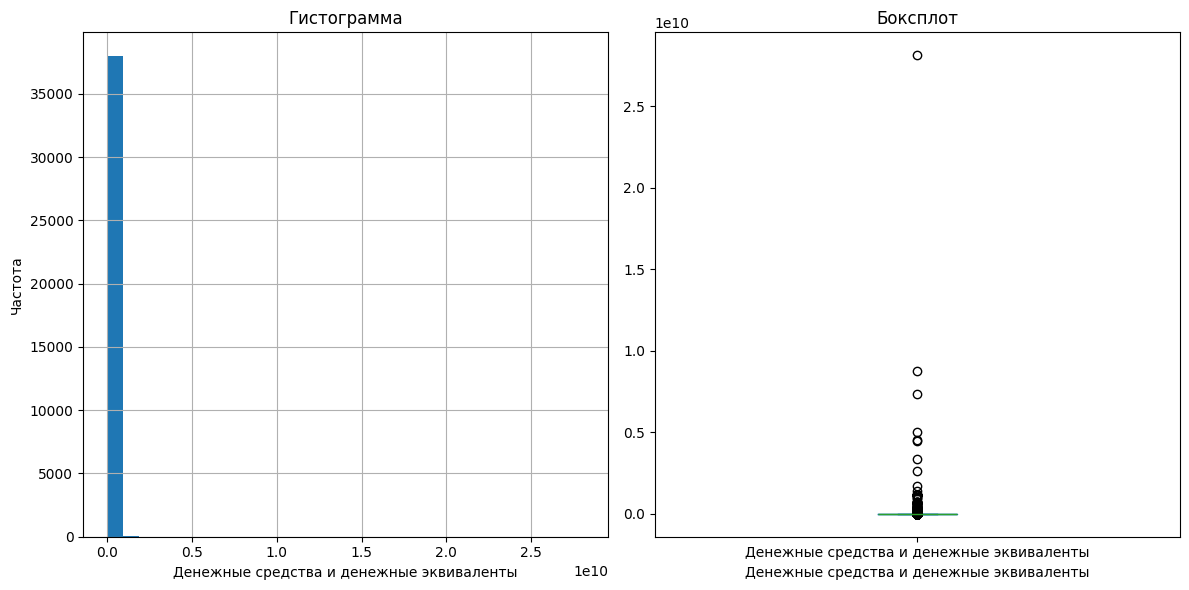

Анализ переменной: Кредиторская задолженность
Описательная статистика:
count    3.759600e+04
mean     8.354940e+07
std      1.204967e+09
min     -1.060000e+06
25%      5.260000e+05
50%      3.806000e+06
75%      1.954800e+07
max      1.325062e+11
Name: Кредиторская задолженность, dtype: float64


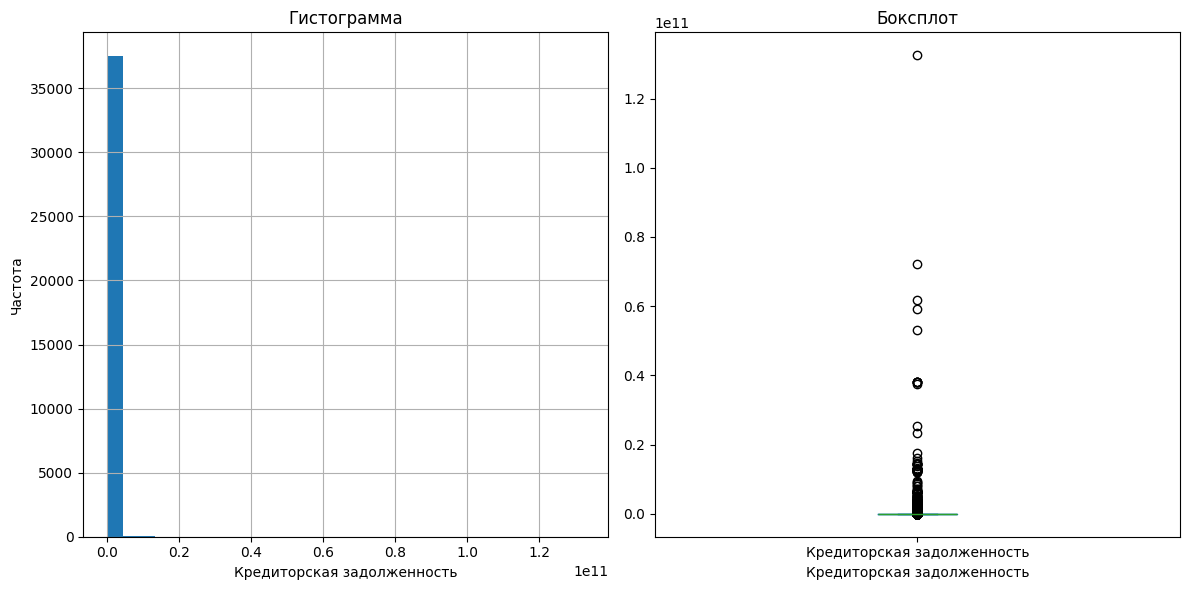

Анализ переменной: Выручка
Описательная статистика:
count    3.797500e+04
mean     1.198784e+08
std      1.621030e+09
min     -4.499000e+06
25%      3.393500e+06
50%      1.282400e+07
75%      4.536600e+07
max      2.173980e+11
Name: Выручка, dtype: float64


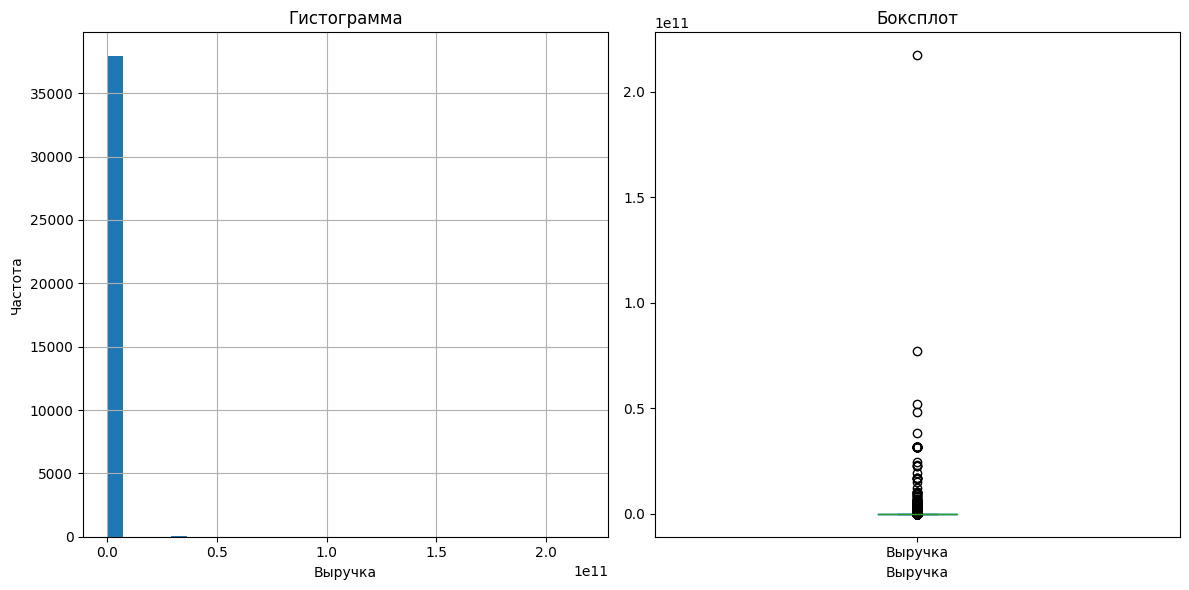

Анализ переменной: Чистая прибыль (убыток)
Описательная статистика:
count    3.832500e+04
mean    -8.043096e+06
std      2.548133e+08
min     -3.319791e+10
25%      0.000000e+00
50%      1.660000e+05
75%      1.074000e+06
max      5.257868e+09
Name: Чистая прибыль (убыток), dtype: float64


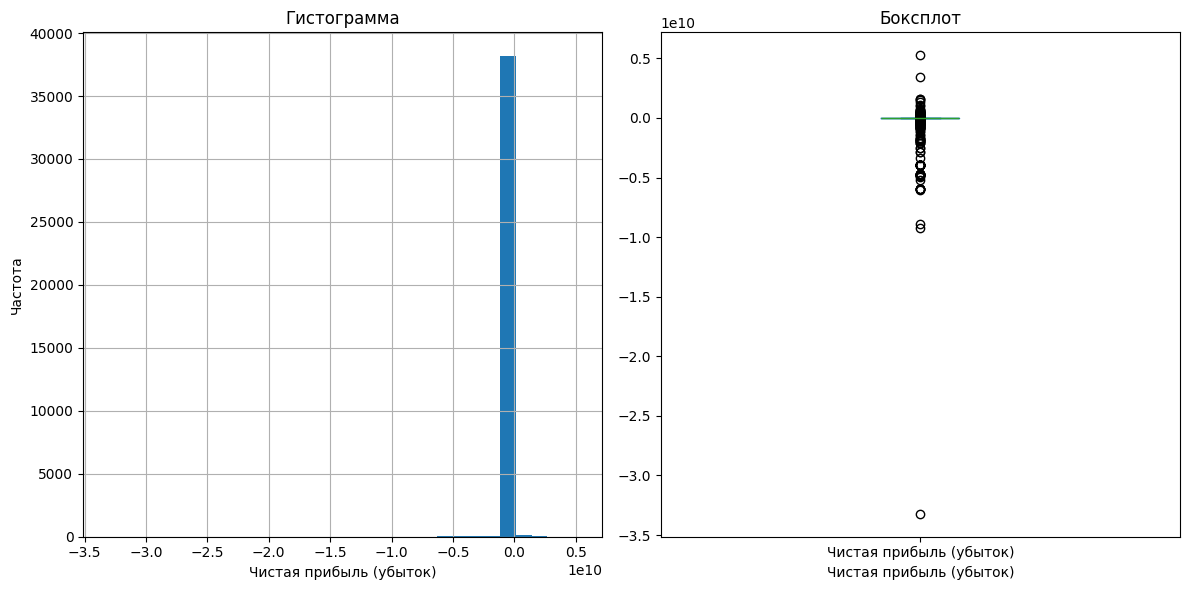

In [118]:
# Список переменных для анализа
variables = [
    'Денежные средства и денежные эквиваленты',
    'Кредиторская задолженность',
    'Выручка',
    'Чистая прибыль (убыток)'
]

# Функция для вывода описательной статистики и визуализации
def analyze_variable(data, variable):
    print(f"Анализ переменной: {variable}")
    print("Описательная статистика:")
    print(data[variable].describe())
    
    # Визуализация гистограммы
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    data[variable].hist(bins=30)
    plt.title('Гистограмма')
    plt.xlabel(variable)
    plt.ylabel('Частота')

    # Визуализация боксплота
    plt.subplot(1, 2, 2)
    data[variable].plot(kind='box')
    plt.title('Боксплот')
    plt.xlabel(variable)
    
    plt.tight_layout()
    plt.show()

# Анализ каждой переменной
for var in variables:
    analyze_variable(df, var)

In [126]:
# Список переменных для анализа
variables = [
    'Денежные средства и денежные эквиваленты',
    'Кредиторская задолженность',
    'Выручка',
    'Чистая прибыль (убыток)'
]

# Функция для вывода описательной статистики и визуализации
def analyze_variable(data, variable):
    print(f"Анализ переменной: {variable}")
    print("Описательная статистика:")
    print(data[variable].describe())
    
    # Обработка выбросов с помощью процентилей
    lower_bound = data[variable].quantile(0.05)
    upper_bound = data[variable].quantile(0.95)
    filtered_data = data[(data[variable] >= lower_bound) & (data[variable] <= upper_bound)]
    
    # Визуализация гистограммы
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    filtered_data[variable].hist(bins=30)
    plt.title('Гистограмма (95-й перцентиль)')
    plt.xlabel(variable)
    plt.ylabel('Частота')

    # Визуализация боксплота
    plt.subplot(1, 2, 2)
    filtered_data[variable].plot(kind='box')
    plt.title('Боксплот (95-й перцентиль)')
    plt.xlabel(variable)
    
    plt.tight_layout()
    #plt.show()
    # Сохранение графиков с уникальным именем для каждой переменной
    filename = f"D:\\Рабочий стол\\educ\\Госзакупки\\histograms_graphs_charts\\ЮЛ\\распределение по {variable}.png"
    plt.savefig(filename)
    plt.close()  # Закрытие фигуры после сохранения

# Анализ каждой переменной
for var in variables:
    analyze_variable(df, var)

Анализ переменной: Денежные средства и денежные эквиваленты
Описательная статистика:
count    3.801800e+04
mean     6.125816e+06
std      1.682302e+08
min     -1.297500e+07
25%      1.700000e+04
50%      2.220000e+05
75%      1.296750e+06
max      2.813250e+10
Name: Денежные средства и денежные эквиваленты, dtype: float64
Анализ переменной: Кредиторская задолженность
Описательная статистика:
count    3.759600e+04
mean     8.354940e+07
std      1.204967e+09
min     -1.060000e+06
25%      5.260000e+05
50%      3.806000e+06
75%      1.954800e+07
max      1.325062e+11
Name: Кредиторская задолженность, dtype: float64
Анализ переменной: Выручка
Описательная статистика:
count    3.797500e+04
mean     1.198784e+08
std      1.621030e+09
min     -4.499000e+06
25%      3.393500e+06
50%      1.282400e+07
75%      4.536600e+07
max      2.173980e+11
Name: Выручка, dtype: float64
Анализ переменной: Чистая прибыль (убыток)
Описательная статистика:
count    3.832500e+04
mean    -8.043096e+06
std      2